In [3]:
%matplotlib inline
import os
import math
import shutil
import pickle
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import IPython.display as ipd

import librosa
from librosa.display import specshow

from IPython.display import Audio, display

In [4]:
# check permissions
# read
DATA_FOLDER = '/projects/data/data_v_7_stc'
METAFOLDER = os.path.join(DATA_FOLDER, 'meta')
METAFILE = os.path.join(METAFOLDER, 'meta.txt')
AUDIO_FOLDER = os.path.join(DATA_FOLDER, 'audio')

In [5]:
df = pd.read_csv(METAFILE, sep='\t', header=None)
df.columns = ['file', 'unk1', 'unk2', 'duration', 'type']

In [6]:
df.sample(5)

,file,unk1,unk2,duration,type
7959,t_knocking_door_0008_time_stretch_6.wav,office,0,1.200499,knocking_door
7800,tt_kd_0015_time_stretch_3.wav,office,0,5.204263,knocking_door
6678,tt_k_0006.wav,office,0,8.082500,keyboard
9864,tool_0217.wav,office,0,4.000000,tool
1854,bg_0140.wav,office,0,2.004688,bags


# Find file count of each type

In [5]:
rows_count = lambda df, t: len(df.loc[df['type'] == t].index)
type_freqs = {name: rows_count(df, name) for name in df['type'].unique()}

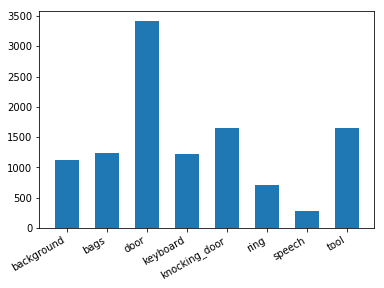

In [6]:
plt.bar(range(len(type_freqs)), list(type_freqs.values()), align='center', width=0.6)
plt.xticks(range(len(type_freqs)), list(type_freqs.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right') 
 
plt.show()

# Find average durations

In [34]:
avg_duration = lambda df, t: df.loc[df['type'] == t]['duration'].mean()
type_avg_durations = {name: avg_duration(df, name) for name in uniqs}

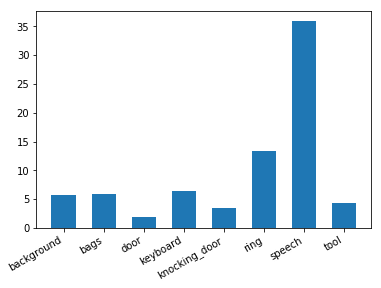

In [35]:
plt.bar(range(len(type_avg_durations)), list(type_avg_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_avg_durations)), list(type_avg_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Find total durations

In [36]:
total_duration = lambda df, t: df.loc[df['type'] == t]['duration'].sum()
type_durations = {name: total_duration(df, name) for name in uniqs}

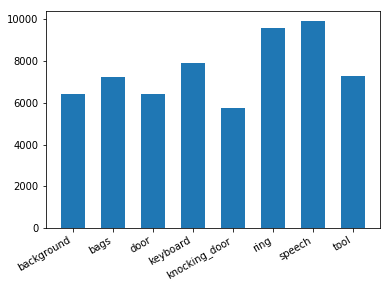

In [37]:
plt.bar(range(len(type_durations)), list(type_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_durations)), list(type_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Analyze sounds

### Histogram of file durations

Text(0.05, 0.5, 'file count')

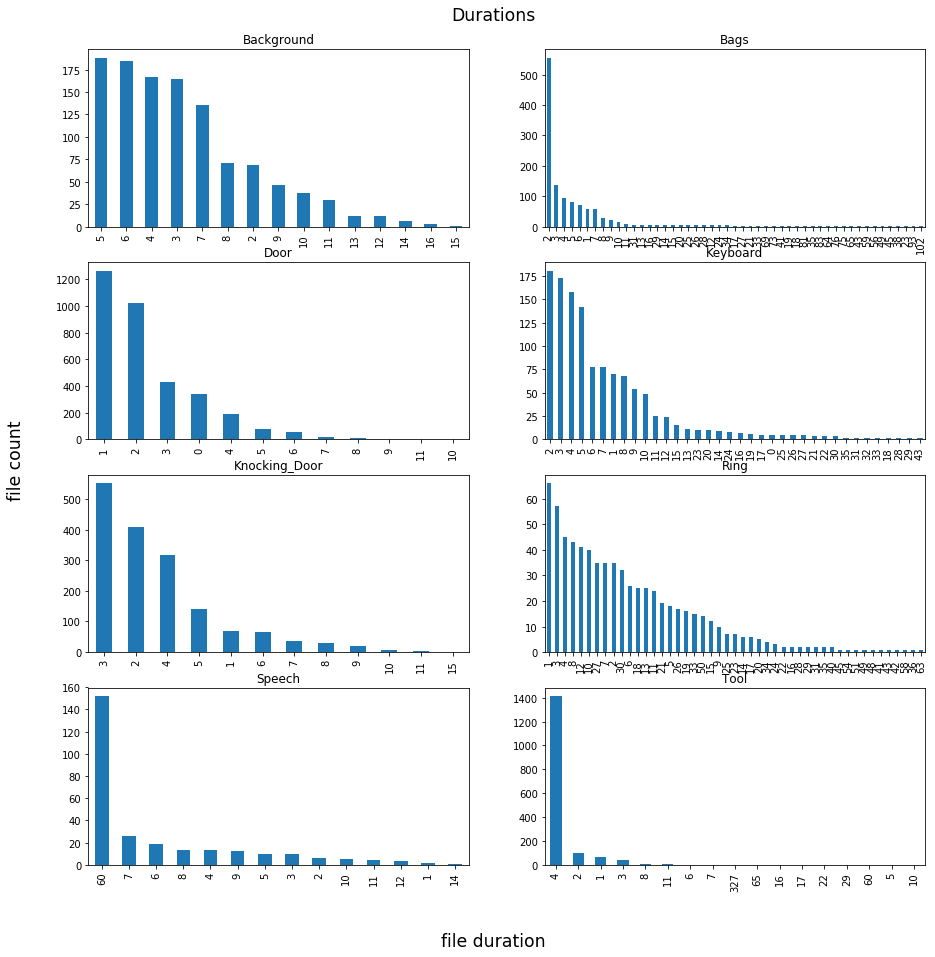

In [5]:
temp_df = pd.DataFrame()
temp_df['duration'] = df['duration'].map(lambda x: round(x))
temp_df['type'] = df['type']

fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = temp_df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    temp_df.loc[temp_df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

# Process data

## Pickle features

In [13]:
from processing.extractor import FeatureExtractor
from model.batcher import Batcher
from model.config import Config
from model.model import CNN
from random import shuffle, choice

In [8]:
config = Config()
extractor = FeatureExtractor(config)
out_path = os.path.join(DATA_FOLDER, 'features.pickle')

In [6]:
features = []
prepared_df = pd.get_dummies(df, columns=['type'])

for _, row in tqdm(prepared_df.iterrows()):
    file = row['file']
    filepath = os.path.join(AUDIO_FOLDER, file)
    for mels_pack in extractor.get_mels(filepath):
        log_mels = extractor.reshape(mels_pack)
        features.append({
            'file': file,
            'type': row.values[4:].astype(int),
            'log_mel': log_mels,
        })
    
with open(out_path, 'wb') as f:
    pickle.dump(features, f)    

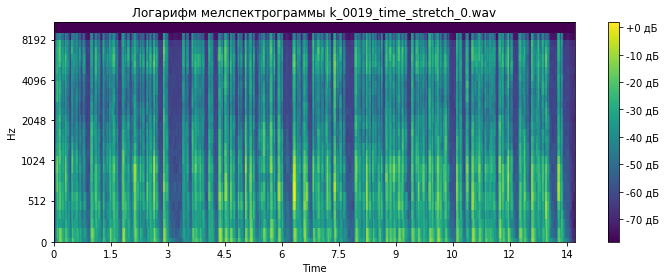

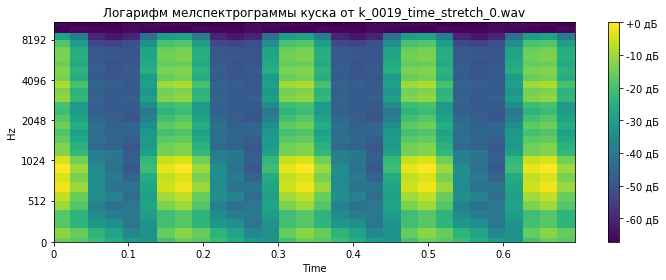

In [54]:
feature = choice(features)

filepath = os.path.join(AUDIO_FOLDER, feature['file'])
y, sr = librosa.load(filepath)
mels = librosa.feature.melspectrogram(y,
                                      n_fft=config.frame_size,
                                      hop_length=config.hop,
                                      n_mels=config.mels_count,
                                      fmax=22050//2)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mels), y_axis='mel',
         fmax=22050//2, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы {}'.format(feature['file']))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(feature['log_mel'][:, :, 0], y_axis='mel',
         fmax=22050//2, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы куска от {}'.format(feature['file']))
plt.tight_layout()
plt.show()

display(Audio(filename=filepath))

In [9]:
with open(out_path, 'rb') as f:
    features = pickle.load(f)

# Create smth for ml

In [10]:
shuffle(features)
threshold = int(len(features)*0.8)

x_train = [f['log_mel'] for f in features[:threshold]]
y_train = [f['type'] for f in features[:threshold]]

x_test = [f['log_mel'] for f in features[threshold:]]
y_test = [f['type'] for f in features[threshold:]]

model = CNN(config).get_model()
model.fit_generator(Batcher(x_train, y_train),
                    steps_per_epoch=50,
                    epochs=50,
                    validation_data=Batcher(x_test, y_test),
                    verbose=1)

Epoch 1/50
50/50 [==============================] - 5s 97ms/step - loss: 13.1475 - acc: 0.1800 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 2/50
50/50 [==============================] - 4s 85ms/step - loss: 13.4103 - acc: 0.1680 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 3/50
50/50 [==============================] - 4s 84ms/step - loss: 13.4506 - acc: 0.1655 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 4/50
50/50 [==============================] - 4s 84ms/step - loss: 13.0798 - acc: 0.1885 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 5/50
50/50 [==============================] - 5s 101ms/step - loss: 13.2652 - acc: 0.1770 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 6/50
50/50 [==============================] - 4s 86ms/step - loss: 13.1443 - acc: 0.1845 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 7/50
50/50 [==============================] - 4s 88ms/step - loss: 12.9428 - acc: 0.1970 - val_loss: 13.2216 - val_acc: 0.1797
Epoch 8/50
50/50 [==============================] - 5s 91ms/step - l

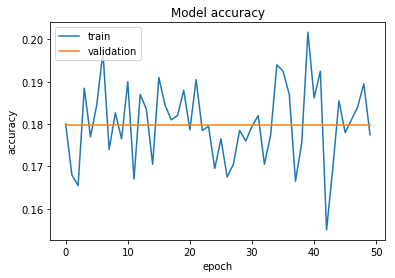

In [11]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

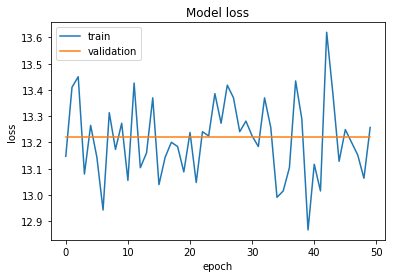

In [12]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()